# Business problem
## Classification Project
## Loan approval analysis

### About this file
* Data set taken from : https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

### Problem Statement
#### About Company
* Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

### Problem
* Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

### ***Data Understanding***
* There are sales data available for 45 stores of Walmart in Kaggle. This is the data that covers sales from 2010-02-05 to 2012-10-26.

### ***The data contains these features***
  * This file contains anonymized information about the 45 stores, additional data related to the store and regional activity for the given dates. It contains the following fields:

>__Loan_Approval_Analysis.csv__
  * Loan_Id : Unique Loan ID
  * Gender : Male/Female
  * Married : Applicant married (Y/N)
  * Dependents : Number of dependents
  * Education : Applicant Education (Graduate/Under Graduate)
  * Self_Employed : Self employed (Y/N)
  * ApplicantIncome : Applicant income
  * CoapplicantIncome : Coapplicant income
  * LoanAmount : Loan amount in thousands
  * Loan_Amount_Term : Term of loan in months
  * Credit_History : Credit history meets guidelines
  * Property_Area : Urban/Semi Urban/Rural
  * Loan_Status : Loan approved (Y/N)
      

# **Data Acquisition**


### Import Library

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

# Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Tools for classification analysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Tuning model
from sklearn.model_selection import GridSearchCV

### Collecting Data

In [189]:
missing_sign = ['n/a', 'na', 'nan', '--,' 'none', 'NaN']
df_loan = pd.read_csv('loan_train.csv', na_values=missing_sign)

In [190]:
df_loan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [191]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [192]:
df_loan.describe(include='all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614,601,611,599,614,582,614.000000,614.000000,592.000000,600.00000,564.000000,614,614
unique,614,2,2,4,2,2,NaN,NaN,NaN,NaN,NaN,3,2
top,LP001002,Male,Yes,0,Graduate,No,NaN,NaN,NaN,NaN,NaN,Semiurban,Y
freq,1,489,398,345,480,500,NaN,NaN,NaN,NaN,NaN,233,422
mean,NaN,NaN,NaN,NaN,NaN,NaN,5403.459283,1621.245798,146.412162,342.00000,0.842199,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,6109.041673,2926.248369,85.587325,65.12041,0.364878,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.000000,9.000000,12.00000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2877.500000,0.000000,100.000000,360.00000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3812.500000,1188.500000,128.000000,360.00000,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5795.000000,2297.250000,168.000000,360.00000,1.000000,NaN,NaN


# **Data Preparation**


In [193]:
df_prep = df_loan.copy()

In [194]:
# Delete column unused
df_prep.drop('Loan_ID', axis=1, inplace=True)

In [195]:
# Determine data type
cat_cols = [column for column in df_prep.columns if df_prep[column].nunique() <= 10]
df_prep[cat_cols] = df_prep[cat_cols].astype('category')
num_cols = [column for column in df_prep.columns if df_prep[column].dtype in ['int64', 'float64']]
print(f"Numerical columns : {num_cols}\nCategorical columns : {cat_cols}")

Numerical columns : ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
Categorical columns : ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


## Exploratory data analysis

### Univariate Analysis

In [196]:
def plot_qty_values(data, nrows=3, ncols=3):
  count = 0
  cat_cols = [column for column in data.columns if data[column].dtypes in ['category']]
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,15))
  for row in range(nrows):
    for col in range(ncols):
      df_count = data[cat_cols[count]].value_counts(normalize=True).to_frame(name='Count')
      sns.barplot(x=df_count.index,
                  y=df_count['Count'],
                  order=df_count.index,
                  ax=ax[row,col])
      for x, y in enumerate(df_count.iterrows()):
        ax[row,col].text(x, y[1]['Count']+0.005, '{:.2f}'.format(y[1]['Count']), ha='center', color='gray')
        ax[row,col].set(ylabel=None)
        ax[row,col].set(title=cat_cols[count])
        ax[row,0].set(ylabel='Percentage of value')
      count += 1

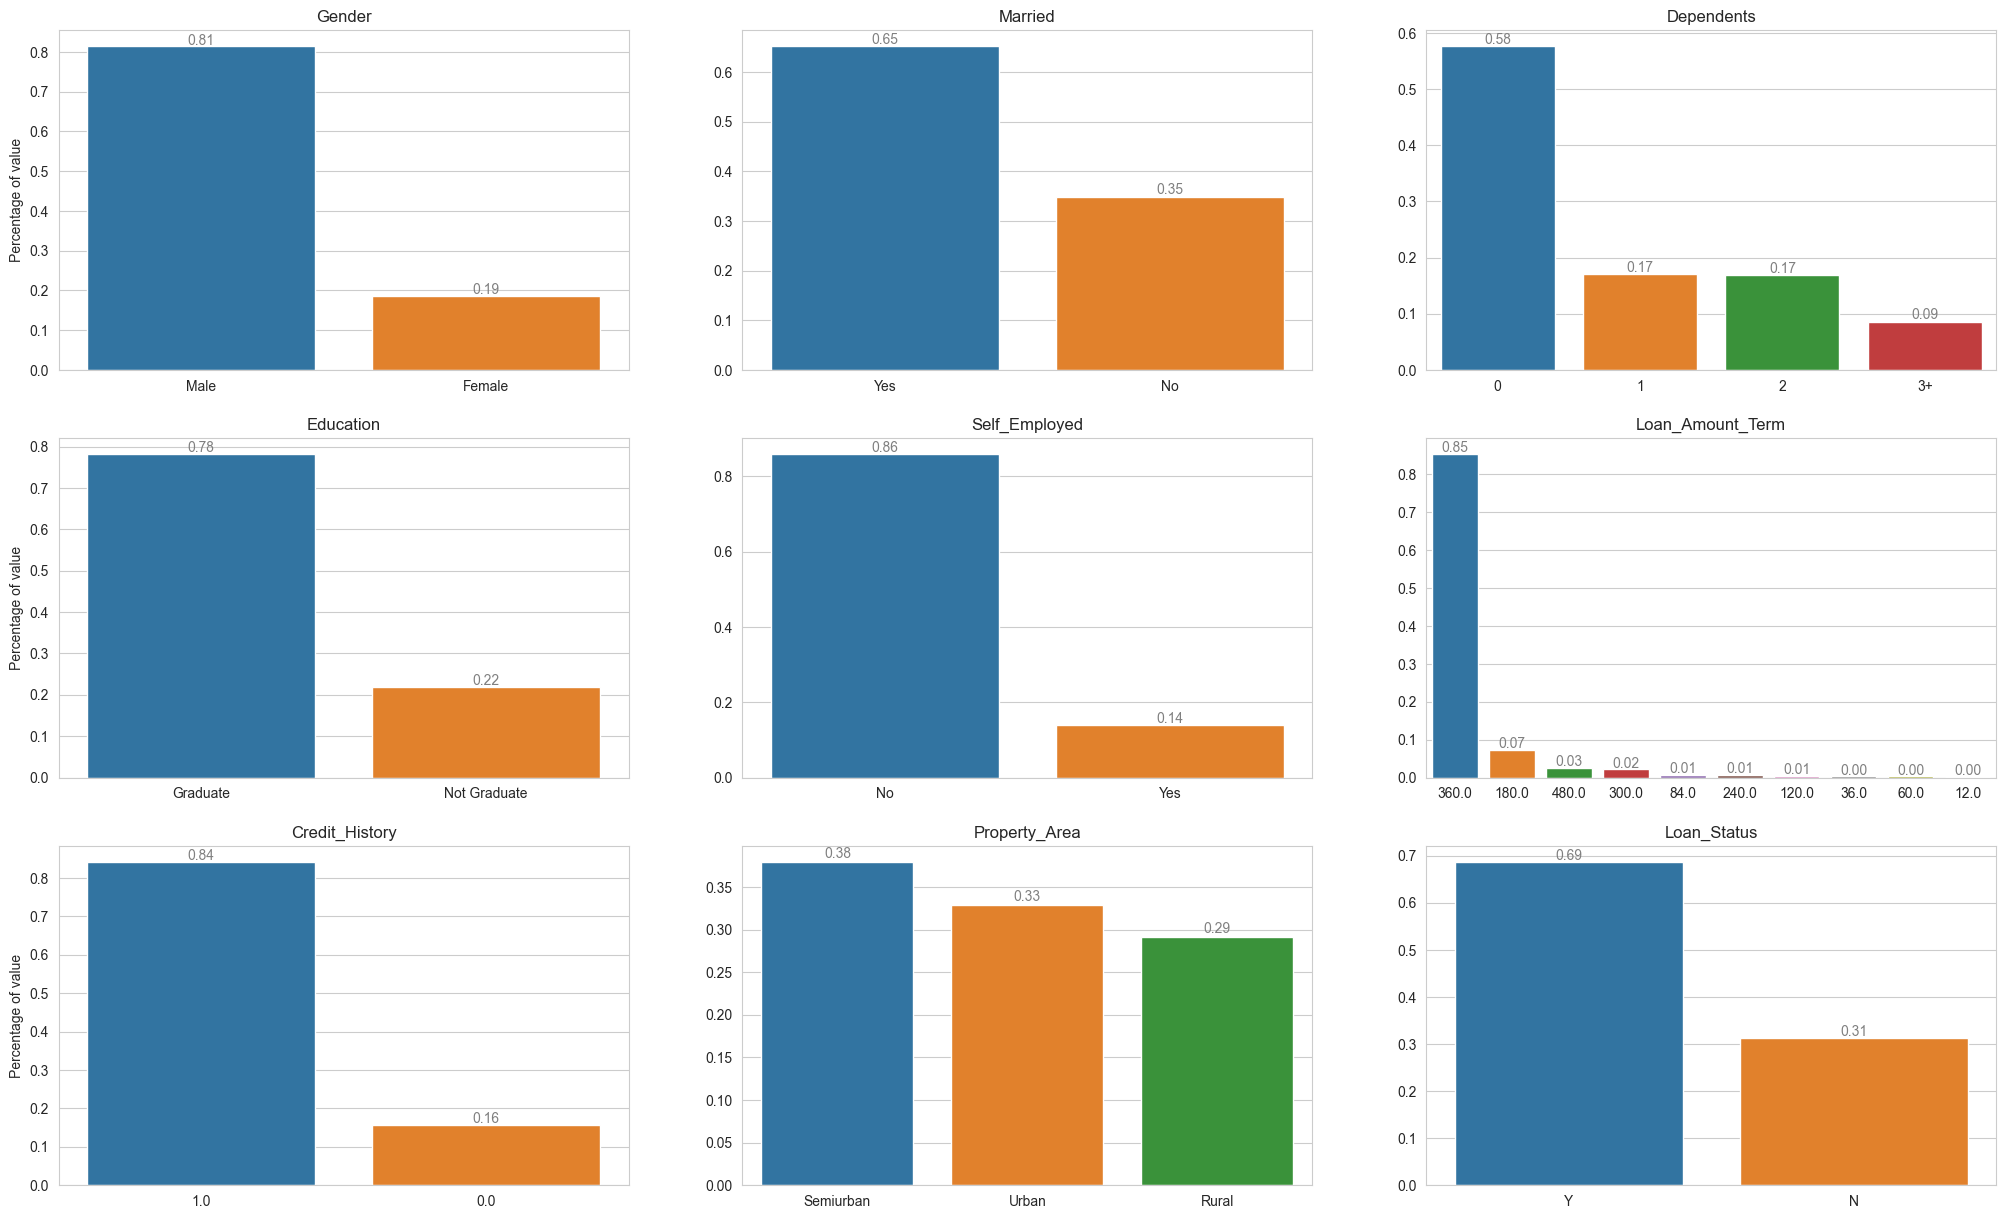

In [197]:
plot_qty_values(df_prep)

In [198]:
# Numerical type
def plot_histograms(data):
  num_cols = data.select_dtypes(include=['int64', 'float64']).columns
  ncols = len(num_cols)
  fig, (ax_box, ax_hist) = plt.subplots(nrows=2, ncols=ncols, gridspec_kw={'height_ratios':(.15, .85)}, figsize=(25,5))
  for idx, column in enumerate(num_cols):
    sns.boxplot(data=data, x=column, ax=ax_box[idx])
    sns.histplot(data=data, x=column, kde=True, ax=ax_hist[idx])
    if idx != 0:
      ax_hist[idx].set(ylabel='')
    ax_box[idx].set(xlabel='')

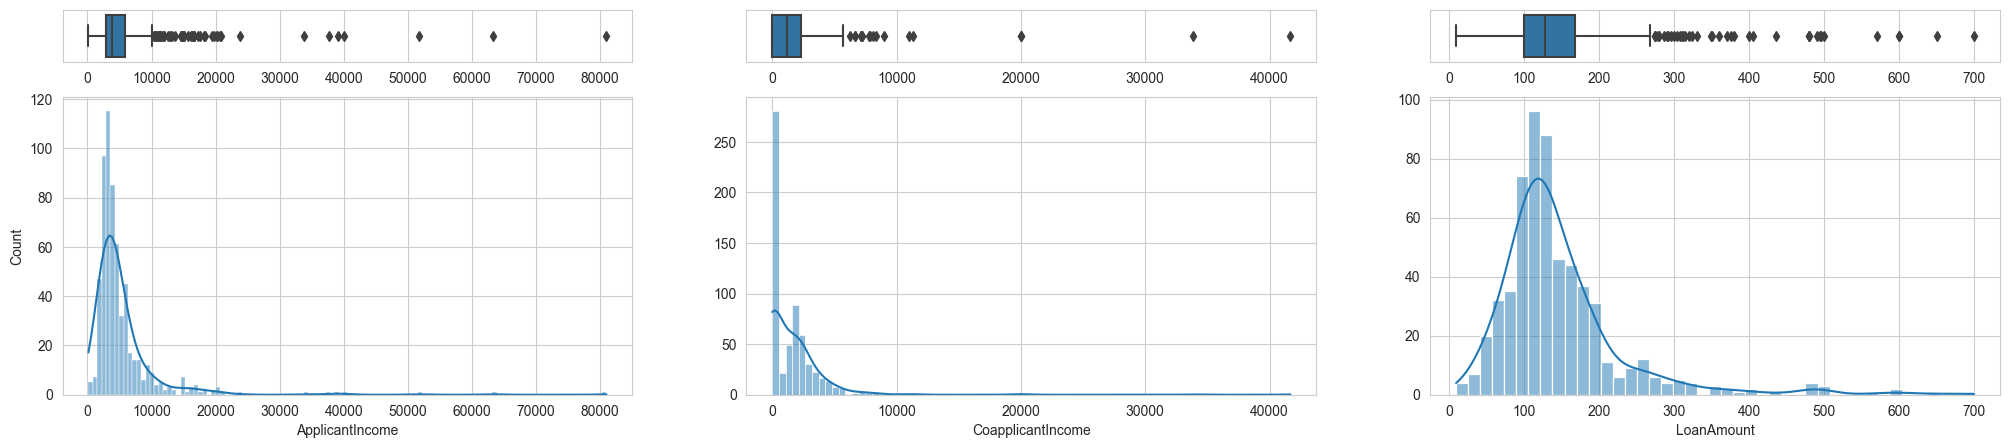

In [199]:
plot_histograms(df_prep)

### Bivariate Analysis

In [200]:
def bivariate_plot(data, target, nrows=4, ncols=2):
  count = 0
  feature = [column for column in data.columns if data[column].dtypes in ['category']]
  feature.remove(target)
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,15))
  for row in range(nrows):
    for col in range(ncols):
      df_cross = pd.crosstab(data[feature[count]], data[target])
      df_cross.div(df_cross.sum(1), axis=0).plot(kind='bar',
                                                 stacked=True,
                                                 ax=ax[row,col])
      ax[row,col].tick_params(axis='x', rotation=0)
      ax[row,0].set(ylabel='Percentage of value')
      count += 1

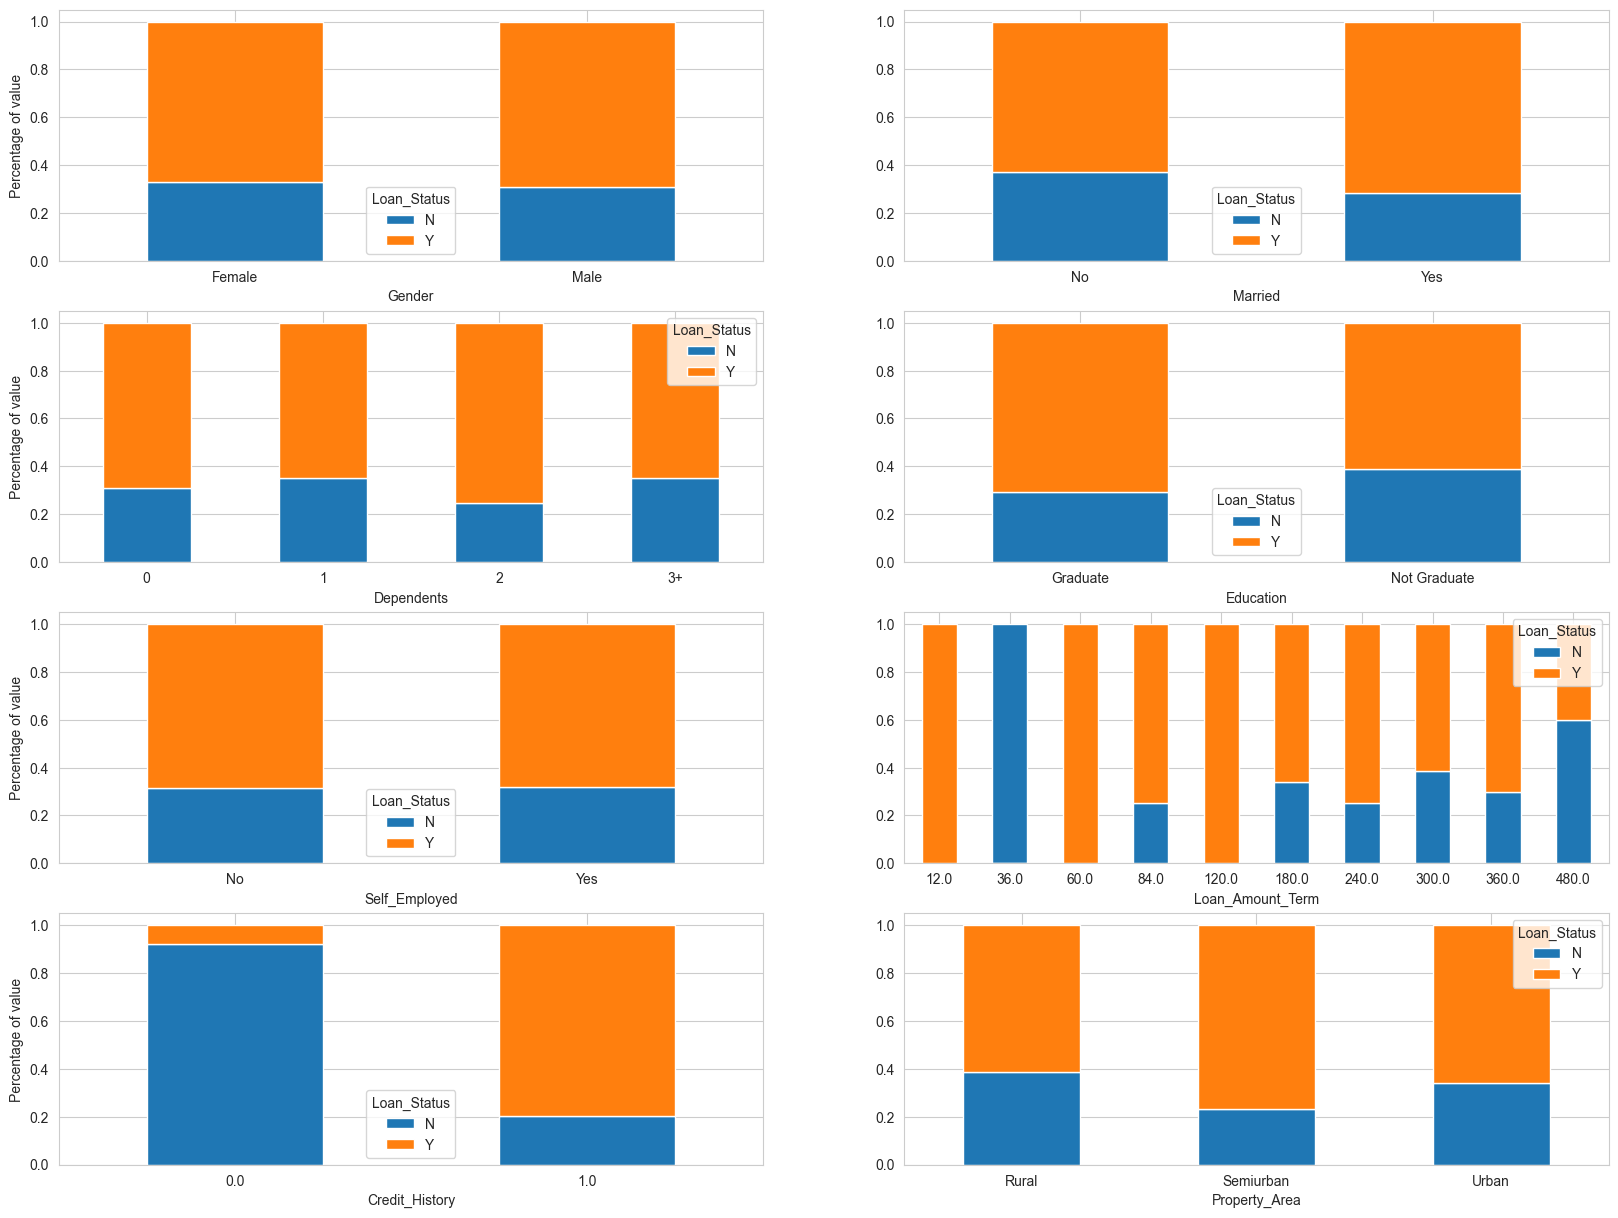

In [201]:
target = 'Loan_Status'
bivariate_plot(df_prep, target)

## Data Cleaning

In [202]:
df_cleanMiss = df_prep.copy()

### Missing value

In [203]:
def check_miss_values(data):
  missing_count = data.isnull().sum()
  percent_missing = missing_count*100/data.isnull().count()
  total_cell = np.product(data.shape)
  total_missing = missing_count.sum()*100/total_cell
  print("Percenct Missing Value Each Columns\n{}".format(percent_missing.round(2)))
  print("Total missing values : {:.2f}%".format(total_missing))

In [204]:
# Handle missing value
def impute_mode_value(data, column):
  mode_value = data[column].mode()[0]
  data[column].fillna(mode_value, inplace=True)

def impute_median_value(data, column):
  median_value = data[column].median()
  data[column].fillna(median_value, inplace=True)

def impute_miss_value(data):
  for column in data.columns:
    if column in cat_cols:
      impute_mode_value(data, column)
    else:
      impute_median_value(data, column)

In [205]:
check_miss_values(df_cleanMiss)

Percenct Missing Value Each Columns
Gender               2.12
Married              0.49
Dependents           2.44
Education            0.00
Self_Employed        5.21
ApplicantIncome      0.00
CoapplicantIncome    0.00
LoanAmount           3.58
Loan_Amount_Term     2.28
Credit_History       8.14
Property_Area        0.00
Loan_Status          0.00
dtype: float64
Total missing values : 2.02%


In [206]:
impute_miss_value(df_cleanMiss)

In [207]:
check_miss_values(df_cleanMiss)

Percenct Missing Value Each Columns
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64
Total missing values : 0.00%


### Outlier

In [208]:
df_cleanOut = df_cleanMiss.copy()

In [209]:
# Identifying Outliers with IQR (Interquartile range)
def clean_outlier_iqr(data):
    count = 1
    num_cols = [column for column in data.columns if data[column].dtypes in ['int64', 'float64']]
    while count != 0:
        count = 0
        for column in num_cols:
            q1 = data[column].quantile(0.25)
            q3 = data[column].quantile(0.75)
            iqr = q3-q1
            upper_whisker = q3+(1.5*iqr)
            lower_whisker = q1-(1.5*iqr)
            idx_out = data.loc[(data[column]>upper_whisker) | (data[column]<lower_whisker)].index
            data.drop(idx_out, inplace=True)
            count += len(idx_out)
    qty_outlier = df_cleanMiss.shape[0]-data.shape[0]
    percent_outlier = (qty_outlier*100)/df_cleanMiss.shape[0]
    print("Outlier : {} units ({:.2f}%) has been deleted".format(qty_outlier, percent_outlier))
    data.reset_index(drop=True, inplace=True)

In [210]:
clean_outlier_iqr(df_cleanOut)

Outlier : 160 units (26.06%) has been deleted


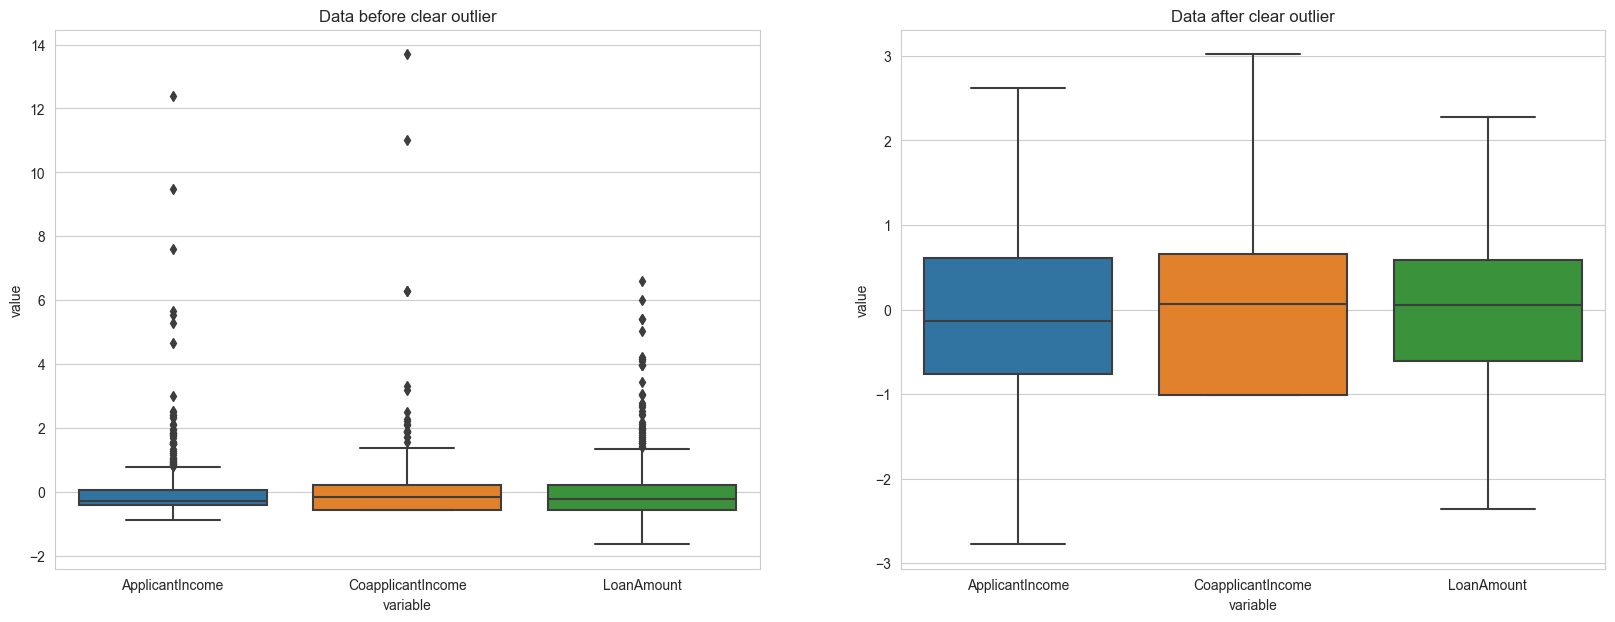

In [211]:
# Plot distribution of data (numerical variable)
fig, ax = plt.subplots(ncols=2, figsize=(20,7))
sns.boxplot(data=pd.melt(zscore(df_cleanMiss[num_cols])),
            x='variable',
            y='value',
            ax=ax[0]
            ).set_title('Data before clear outlier')
sns.boxplot(data=pd.melt(zscore(df_cleanOut[num_cols])),
            x='variable',
            y='value',
            ax=ax[1]
            ).set_title('Data after clear outlier');

## Data transformation

In [212]:
df_trans = df_cleanOut.copy()

In [213]:
df_trans.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [214]:
class Data():
    def __init__(self, data):
        self.data = data
    
    def transform_data(self):
        cat_cols = [column for column in self.data.columns if self.data[column].dtypes in ['category']]
        for column in self.data.columns:
            if column in cat_cols:
                self.__encode_label(column)
            else:
                self.__scale_feature(column)

    def __encode_label(self, column):
        encode = LabelEncoder()
        self.data[column] = encode.fit_transform(self.data[column])

    def __scale_feature(self, column):
        sc = StandardScaler()
        self.data[column] = sc.fit_transform(np.array(self.data[column]).reshape(-1,1))

In [215]:
trans = Data(df_trans)
trans.transform_data()

In [216]:
df_trans.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,1.835521,-1.006059,0.290787,6,1,2,1
1,1,1,1,0,0,0.811155,0.138996,0.290787,6,1,0,0
2,1,1,0,0,1,-0.469707,-1.006059,-1.580088,6,1,2,1
3,1,1,0,1,0,-0.807116,0.784418,0.049384,6,1,2,1
4,1,0,0,0,0,1.957700,-1.006059,0.683067,6,1,2,1


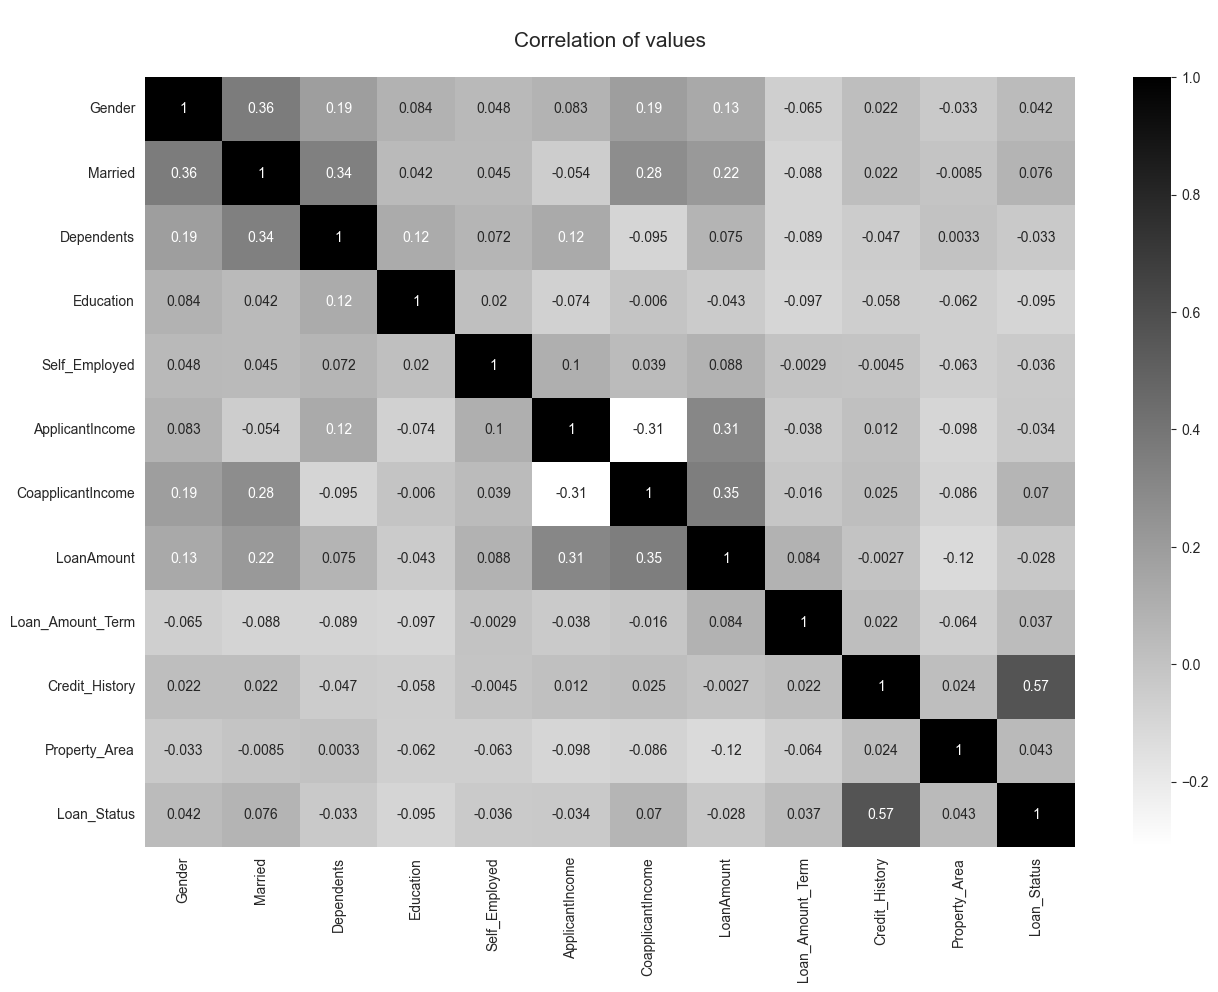

In [217]:
# Check correlation of values
corr = df_trans.corr()
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr, annot=True, cmap='binary')
ax.set_title('\nCorrelation of values\n', fontsize=15);

# **Modeling**

In [218]:
class Splitting_Data(Data):
    def __init__(self, data, target):
        super().__init__(data)
        self.x = self.data.drop(target, axis=1)
        self.y = self.data[target]
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.2, random_state=25)

## Compare model

In [219]:
class Comparing(Splitting_Data):
	def compare_model(self, algorithms):
		r_score = dict()
		for name,model in algorithms.items():
			cvs = cross_val_score(model, self.x, self.y, cv=10)
			r_score[name] = cvs.mean()*100
		return pd.Series(r_score, name='Score(%)')

In [220]:
target = 'Loan_Status'
algorithms = {
    'LogisticRegression' : LogisticRegression(),
    'NaiveBayes' : GaussianNB(),
    'SupportVectorMachine' : SVC(),
    'DecisionTree' : DecisionTreeClassifier(),
    'RandomForest' : RandomForestClassifier()
}

In [221]:
cf = Comparing(df_trans, target)
score = cf.compare_model(algorithms)
print("{}\n\nAlgorithm '{}' has the highest efficiency ({:.2f}%)".format(score, score.idxmax(), score.max()))

LogisticRegression      81.951691
NaiveBayes              81.507246
SupportVectorMachine    81.951691
DecisionTree            70.265700
RandomForest            78.855072
Name: Score(%), dtype: float64

Algorithm 'LogisticRegression' has the highest efficiency (81.95%)


In [222]:
model = algorithms.get(score.idxmax())
model

LogisticRegression()

## Train model

In [223]:
class Training(Splitting_Data):
  def __init__(self, data, target, model):
    super().__init__(data, target)
    self.model = model

  def train_model(self):
    self.model.fit(self.x_train, self.y_train)
    self.__report_model()

  def __report_model(self):
    self.__plot_roc_curve()
    y_predict = self.model.predict(self.x_test)
    report = classification_report(self.y_test, y_predict, target_names=['No','Yes'])
    accuracy = accuracy_score(self.y_test, y_predict)
    cm = confusion_matrix(self.y_test, y_predict)
    print(f'Use algorithm : {model}')
    print('-'*60)
    print(f'Classification Report :\n{report}')
    print('-'*60)
    print(f'Accuracy : {accuracy*100:.4f}%')
    print('-'*60)
    print(f'Confusion Matrix :\n{cm}')
    print('-'*60)

  def __plot_roc_curve(self):
    target_value = 1
    y_predict_proba = self.model.predict_proba(self.x_test)
    fpr, tpr, thresholds = roc_curve(self.y_test, y_predict_proba[:,target_value])
    auc_value = auc(fpr, tpr)
    lower_left = [0,1]
    upper_right = [0,1]
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.plot(lower_left, upper_right, '--r')
    plt.title('ROC curve [AUC : {:.4f}]'.format(auc_value))
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)');

Use algorithm : LogisticRegression()
------------------------------------------------------------
Classification Report :
              precision    recall  f1-score   support

          No       1.00      0.54      0.70        28
         Yes       0.83      1.00      0.91        63

    accuracy                           0.86        91
   macro avg       0.91      0.77      0.80        91
weighted avg       0.88      0.86      0.84        91

------------------------------------------------------------
Accuracy : 85.7143%
------------------------------------------------------------
Confusion Matrix :
[[15 13]
 [ 0 63]]
------------------------------------------------------------


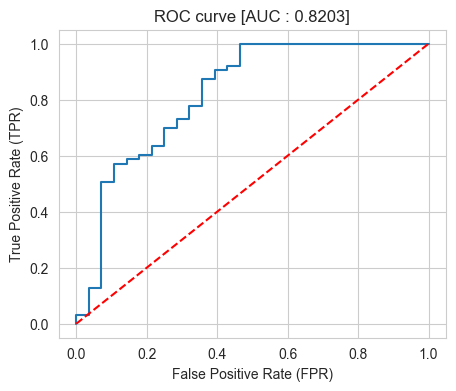

In [224]:
train = Training(df_trans, target, model)
train.train_model()

## Tune model

In [225]:
class Tuning(Training):
  def tune_model(self, param_dist, max_loop):
    self.__find_parameter(param_dist)
    self.__adjust_threshold(max_loop)
    self.__report_model()
    self.model = self.new_model

  def __find_parameter(self, param_dist):
    all_process = -1
    lr_search = GridSearchCV(estimator=self.model, param_grid=param_dist, n_jobs=all_process)
    lr_search.fit(self.x_train, self.y_train)
    self.new_model = lr_search.best_estimator_

  def __adjust_threshold(self, max_loop):
    r_score = dict()
    for round in range(max_loop):
      threshold = (round+1)/max_loop
      y_predict_proba = self.new_model.predict_proba(self.x_test)[:,1]
      y_predict = y_predict_proba > threshold
      acc_score = accuracy_score(self.y_test, y_predict)
      r_score[threshold] = acc_score
    score = pd.Series(r_score, name='Score(%)')
    self.my_threshold = score.idxmax()

  def __report_model(self):
    y_predict_proba = self.new_model.predict_proba(self.x_test)[:,1]
    y_predict = y_predict_proba > self.my_threshold
    report = classification_report(self.y_test, y_predict, target_names=['No','Yes'])
    accuracy = accuracy_score(self.y_test, y_predict)
    cm = confusion_matrix(self.y_test, y_predict)
    print(f'Use algorithm : {self.new_model}')
    print('-'*60)
    print(f'Threshold : {self.my_threshold}')
    print('-'*60)
    print(f'Classification Report :\n{report}')
    print('-'*60)
    print(f'Accuracy : {accuracy*100:.4f}%')
    print('-'*60)
    print(f'Confusion Matrix :\n{cm}')
    print('-'*60)

In [226]:
param_dist = {
    'C' : [0.001,0.01, 0.1, 1, 10,100],
    'penalty' : ['l1', 'l2'],
    'max_iter' : list(range(100, 800, 100)),
    'solver' : ['liblinear']
}

In [227]:
tune = Tuning(df_trans, target, model)
tune.tune_model(param_dist, 1_000)

Use algorithm : LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
------------------------------------------------------------
Threshold : 0.729
------------------------------------------------------------
Classification Report :
              precision    recall  f1-score   support

          No       1.00      0.57      0.73        28
         Yes       0.84      1.00      0.91        63

    accuracy                           0.87        91
   macro avg       0.92      0.79      0.82        91
weighted avg       0.89      0.87      0.86        91

------------------------------------------------------------
Accuracy : 86.8132%
------------------------------------------------------------
Confusion Matrix :
[[16 12]
 [ 0 63]]
------------------------------------------------------------


# **Feature Engineering**

In [228]:
new_df = df_cleanOut.copy()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             454 non-null    category
 1   Married            454 non-null    category
 2   Dependents         454 non-null    category
 3   Education          454 non-null    category
 4   Self_Employed      454 non-null    category
 5   ApplicantIncome    454 non-null    int64   
 6   CoapplicantIncome  454 non-null    float64 
 7   LoanAmount         454 non-null    float64 
 8   Loan_Amount_Term   454 non-null    category
 9   Credit_History     454 non-null    category
 10  Property_Area      454 non-null    category
 11  Loan_Status        454 non-null    category
dtypes: category(9), float64(2), int64(1)
memory usage: 16.2 KB


In [229]:
# Convert data type
new_df['Loan_Amount_Term'] = new_df['Loan_Amount_Term'].astype('float64')

### Creating new features

In [230]:
new_df['LoanAmount'] = new_df['LoanAmount']*1_000

# Lets assume that interest rate = 10% per year
month_in_year = 12
interest_per_year = 0.1
interest_per_month = interest_per_year/month_in_year
new_df['EMI'] = (new_df['LoanAmount']*interest_per_month*(1+interest_per_month)**new_df['Loan_Amount_Term'])/(((1+interest_per_month)**new_df['Loan_Amount_Term'])-1)
new_df['totalIncome'] = new_df['ApplicantIncome'] + new_df['CoapplicantIncome']

new_df['EMI_per_LoanAmount'] = new_df['EMI']/new_df['LoanAmount']
new_df['EMI_per_totalIncome'] = new_df['EMI']/new_df['totalIncome']
new_df['EMI_per_totalIncome_less_than_30%'] = np.where(new_df['EMI_per_totalIncome'] < 0.30, new_df['EMI_per_totalIncome'], 0)
new_df['EMI_per_totalIncome_more_than_30%'] = np.where(new_df['EMI_per_totalIncome'] > 0.30, new_df['EMI_per_totalIncome'], 0)

In [231]:
income_bucket = ['0', '1', '2', '3']
new_df['totalIncome'] = pd.cut(new_df.totalIncome,
                               bins = [0, 2_000, 4_000, 6_000, np.inf],
                               labels = income_bucket,
                               right = True)

In [232]:
new_df['Loan_Amount_Term'] = new_df['Loan_Amount_Term'].astype('category')

In [233]:
cols_drop = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'EMI', 'EMI_per_totalIncome']
new_df.drop(cols_drop, axis=1, inplace=True)

## Data Transformation

In [234]:
trans = Data(new_df)
trans.transform_data()

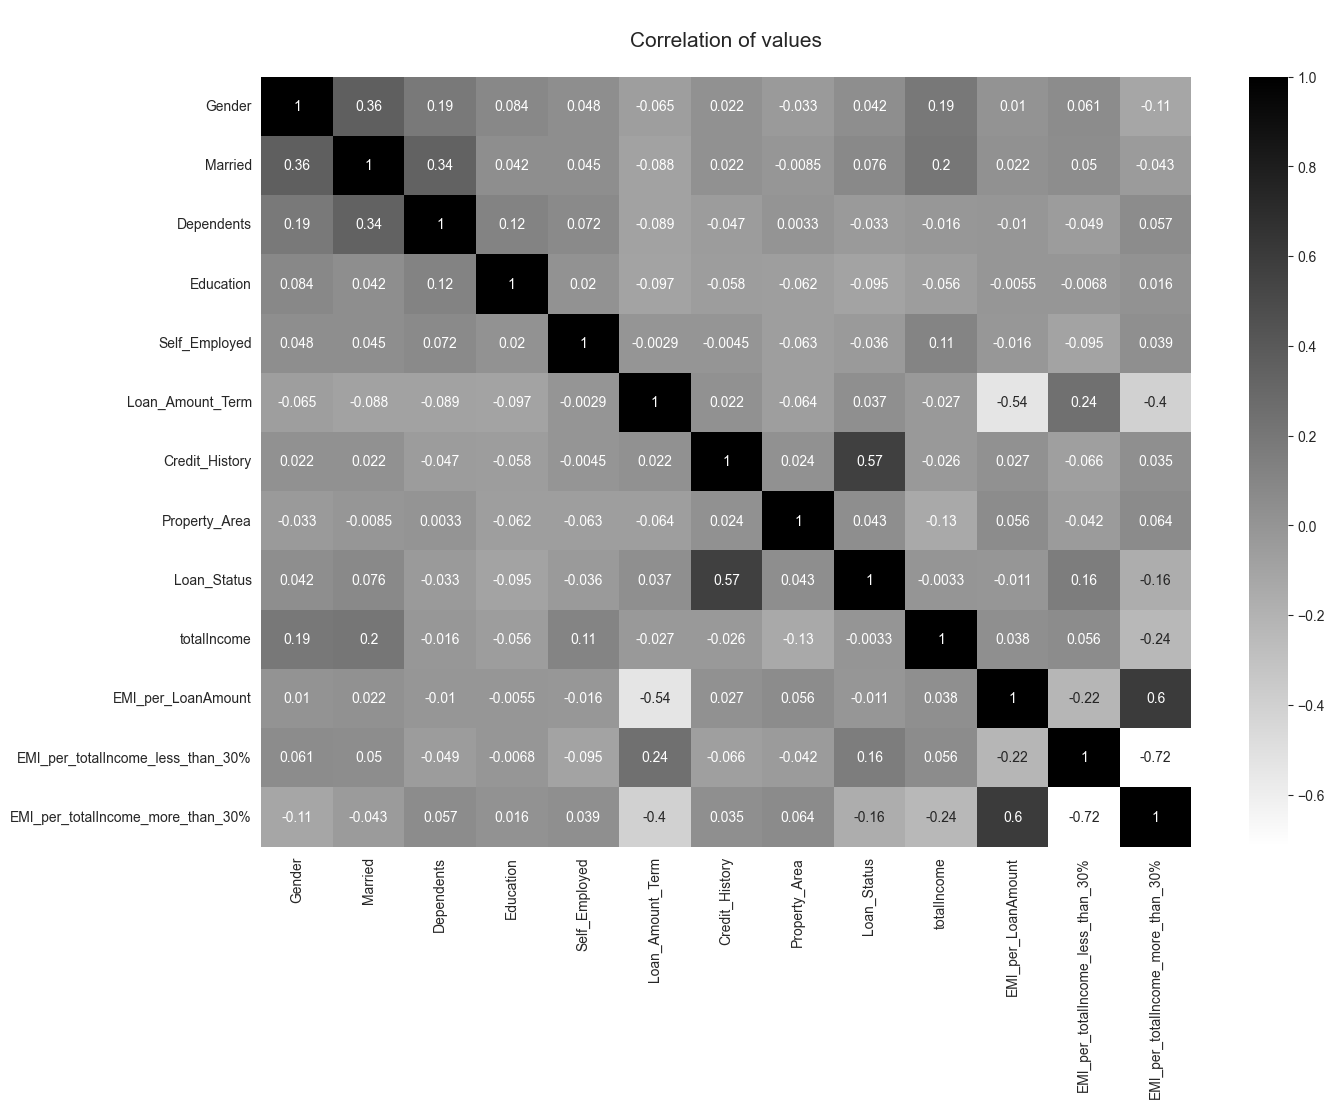

In [235]:
# Check correlation of values
corr = new_df.corr()
plt.figure(figsize=(15, 10))
ax = sns.heatmap(corr, annot=True, cmap='binary')
ax.set_title('\nCorrelation of values\n', fontsize=15);

## Compare model

In [236]:
cf = Comparing(new_df, target)
score = cf.compare_model(algorithms)
print("{}\n\nThe algorithm '{}' has the highest efficiency ({:.2f}%)".format(score, score.idxmax(), score.max()))

LogisticRegression      82.391304
NaiveBayes              81.043478
SupportVectorMachine    82.391304
DecisionTree            72.922705
RandomForest            78.855072
Name: Score(%), dtype: float64

The algorithm 'LogisticRegression' has the highest efficiency (82.39%)


In [237]:
# Choose model has the most efficiency
model = algorithms.get(score.idxmax())
model

LogisticRegression()

## Train model

Use algorithm : LogisticRegression()


------------------------------------------------------------
Classification Report :
              precision    recall  f1-score   support

          No       0.82      0.64      0.72        28
         Yes       0.86      0.94      0.89        63

    accuracy                           0.85        91
   macro avg       0.84      0.79      0.81        91
weighted avg       0.84      0.85      0.84        91

------------------------------------------------------------
Accuracy : 84.6154%
------------------------------------------------------------
Confusion Matrix :
[[18 10]
 [ 4 59]]
------------------------------------------------------------


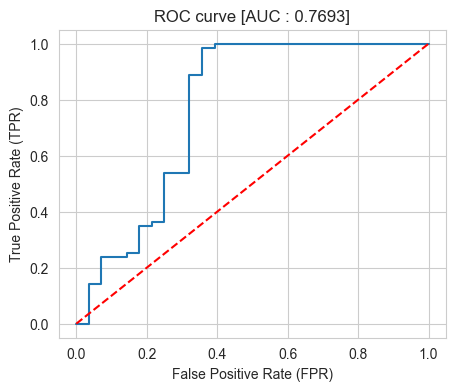

In [238]:
train = Training(new_df, target, model)
train.train_model()

## Tune model

In [239]:
param_dist = {
    'C' : [0.001,0.01, 0.1, 1, 10,100],
    'penalty' : ['l1', 'l2'],
    'max_iter' : list(range(100, 800, 100)),
    'solver' : ['liblinear']
}

In [240]:
tune = Tuning(new_df, target, model)
tune.tune_model(param_dist, 1_000)

Use algorithm : LogisticRegression(C=10, penalty='l1', solver='liblinear')
------------------------------------------------------------
Threshold : 0.334
------------------------------------------------------------
Classification Report :
              precision    recall  f1-score   support

          No       1.00      0.61      0.76        28
         Yes       0.85      1.00      0.92        63

    accuracy                           0.88        91
   macro avg       0.93      0.80      0.84        91
weighted avg       0.90      0.88      0.87        91

------------------------------------------------------------
Accuracy : 87.9121%
------------------------------------------------------------
Confusion Matrix :
[[17 11]
 [ 0 63]]
------------------------------------------------------------
